# Extended MNIST

L'obiettivo del progetto è il riconoscimento e la conseguente classificazione di immagini rappresentati lettere scritte a mano. Il dataset fornito è composto da 80000 immagini di stessa dimensione (28x28), rappresentate in scala di grigi. Non viene fatta distizione tra lettere maiuscole e minuscole, quindi le classi da individuare sono 26.

# Approccio alla soluzione

Verranno utilizzati più modelli per la soluzione al problema, partendo da un modello di base (Logistic Regression) fino ad arrivare a modelli più complessi (Convolutional Neural Network). Le prestazioni di ogni modello verrano giudicate in base all'accuratezza ed al tempo di esecuzione.  I dati sono vengono divisi in 3 set: train (70%), validation (15%) e test set(15%).


In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt

from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier

In [52]:
#utility functions

#time monitor
def elapsed_time(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time spent training: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))

#accuracy printer
def print_accuracy_scores(train_labels, test_labels, predictions_train_model, predictions_test_model):
    acc_train = accuracy_score(train_labels, predictions_train_model)
    acc_test = accuracy_score(test_labels, predictions_test_model)
    print('Training set accuracy:   {:.3f}'.format(acc_train))
    print('Test set accuracy:       {:.3f}'.format(acc_test))

def plot_measure(history_train, history_test, title='', xticks=None):
    plt.figure(figsize=(12, 8))
    plt.plot(history_train, marker='o', markersize=5, label='Train')
    plt.plot(history_test, marker='o', markersize=5, label='Validation')
    plt.legend()
    if xticks is None:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    else:
        #plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax = plt.subplot(111)
        ax.set_xlim(xticks[0], xticks[-1])
        plt.xticks(xticks)
    plt.title(title)
    plt.show()
    
#accuracy printer
def plot_accuracy(history_df):
    plot_measure(history_df.accuracy, history_df.val_accuracy, 'Accuracy')
    
#loss printer
def plot_loss(history_df):
    plot_measure(history_df.loss, history_df.val_loss, 'Loss')

#confusion matrix printer
def plot_confusion_matrix(train_labels, predictions_train):
    plt.figure(figsize=(12,6))
    disp = ConfusionMatrixDisplay.from_predictions(train_labels, predictions_train, normalize='true', cmap='Blues')
    disp.figure_.suptitle("Confusion Matrix")
    plt.grid(None)
    plt.show()
    
def create_flatten_images_array(dataset, array_specs):
    images = np.ndarray((array_specs[0], array_specs[1] * array_specs[2]))
    for i in range(0, len(dataset)):
        images[i] = np.array(dataset[i]).flatten()
    return images

In [53]:
#train validatin test split
def train_validation_test_split(images, labels, test_val_size):
    train_images, test_val_images, train_labels, test_val_labels = train_test_split(images, labels, test_size=test_val_size, random_state=42)
    val_images, test_images, val_labels, test_labels = train_test_split(test_val_images, test_val_labels, test_size=0.5, random_state=42)

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

def create_pds(train_images, val_images, train_labels, val_labels):
    split_index = [-1]*len(train_images) + [0]*len(val_images)
    X = np.concatenate((train_images, val_images), axis=0)
    y = np.concatenate((train_labels, val_labels), axis=0)
    pds = PredefinedSplit(test_fold = split_index)

    return pds, X, y

In [54]:
#reading data from csv

df = pd.read_csv("emnist-letters.csv")
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F")
y = df.iloc[:,0].to_numpy()-1

# Softmax Regression

Prima di applicare ogni modello, attraverso una GridSearch si individua la migliore combinazione dei parametri del modello scelto. A causa dei tempi di esecuzioni troppo elevati, non è stato possibile usare una cross-validation, ma una semplice "1fold".

Nel caso della Softmax Regression, i parametri soggetti a tuning sono:
 - C (il fattore di regolarizzazione)
  - max_iter (il numero massimo di iterazioni del solver).

In [95]:
#splitting data in train, tese and validation and flattening it

images_specs=[len(X),28,28]
images = (create_flatten_images_array(X, images_specs))/255
train_images, train_labels, val_images, val_labels, test_images, test_labels = train_validation_test_split(images, y, 0.3)

pds, X_flat, y_flat = create_pds(train_images, val_images, train_labels, val_labels)

In [56]:
params = {"C":[0.1, 0.01, 0.001],
         "max_iter":[100, 200, 500, 1000]}
clf = GridSearchCV(LogisticRegression(n_jobs=-1), params, scoring='accuracy', return_train_score=True, cv=pds)

time_start = time()

clf.fit(X_flat, y_flat)

time_end = time()
elapsed_time(time_start, time_end)

Time spent training: 00:08:31


In [57]:
clf.best_estimator_

LogisticRegression(C=0.1, max_iter=200, n_jobs=-1)

In [58]:
clf.best_score_

0.7140390390390391

In [59]:
log_reg = LogisticRegression(multi_class='multinomial', n_jobs=-1, C=0.01, max_iter=1000)
time_start = time()
log_reg.fit(train_images, train_labels)
time_end = time()
elapsed_time(time_start, time_end)

predictions_test = log_reg.predict(test_images)
predictions_train = log_reg.predict(train_images)

print_accuracy_scores(train_labels, test_labels, predictions_train, predictions_test)

C:\Users\Damiano\PycharmProjects\machineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Time spent training: 00:00:40
Training set accuracy:   0.716
Test set accuracy:       0.698


# Random forest

Nella Random Forest, i paramteri soggetti a tuning sono:
- n_estimators (il numero di alberi)
- criterion (funzione di impurità)
- min_samples_split (il numeri minimo di elementi di un nodo affinché possa essere partizionato)
- max_depth (profondità dell'albero).

La suddivisione del dataset in train, validatione test set rimane la stessa: 70% train set, 15% test set e 15% validation set.


In [92]:
n_estimators =[50, 100, 200] 
criterion = ["gini", "entropy"]
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256]
max_depth = [1, 5, 10, 20]

def build_random_forest(hp):
    model = RandomForestClassifier(
        n_jobs=-1, 
        random_state=42,
        n_estimators=hp.Choice("n_estimators", n_estimators),
        criterion=hp.Choice("criterion", criterion),
        min_samples_split=hp.Choice("min_samples_split", min_samples_split),
        max_depth=hp.Choice('max_depth', max_depth))
    return model

In [93]:
rf_trials=30
scorer = make_scorer(accuracy_score)

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.RandomSearchOracle(objective=kt.Objective('score', 'max'),max_trials=rf_trials, seed=42),
    scoring=scorer,
    hypermodel= build_random_forest,
    cv=pds,
    project_name='tuners/random_forest')

tuner.search(X_flat, y_flat)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest criterion:        ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best min_samples_split:  ", best_hps.get("min_samples_split"))

Trial 30 Complete [00h 00m 04s]
score: 0.5742492492492492

Best score So Far: 0.8671171171171171
Total elapsed time: 00h 05m 57s

Best criterion:         gini
Best max_depth:           20
Best n_estimators:        200
Best min_samples_split:   8


In [96]:
model = RandomForestClassifier(n_jobs=-1, criterion=best_hps.get("criterion"), 
                               max_depth=best_hps.get("max_depth"), n_estimators=best_hps.get("n_estimators"), min_samples_split=best_hps.get("min_samples_split"))
time_start = time()
model.fit(train_images, train_labels)
time_end = time()
elapsed_time(time_start, time_end) 
print("")

predictions_test = model.predict(test_images)
predictions_train = model.predict(train_images)

print_accuracy_scores(train_labels, test_labels, predictions_train, predictions_test)

Time spent training: 00:00:39

Training set accuracy:   0.988
Test set accuracy:       0.863


# Reti neurali convoluzionali (CNN)

Come ultima tipologia di modello si è scelto di utilizzare una CNN. Verranno analizzati 3 modelli di complessità crescente,  ed ad ogni di essi verrà applicato il tuning degli iperparametri.

In [63]:
#hyperparameters
dense_units = [32, 64, 128, 256]
l2 = [0.01, 0.001, 0.0001]
dropouts_rate = [.20, .30, .40, .50, .60, .70, .80]
filters = [[16,32,64], [32, 64, 128]]
filter = [16, 32, 64, 128, 256]

# Modello 1

Questo modello rappresenta la base per i modelli successivi più complessi. Esso non presenta un layer per la convoluzione, quindi non è classificabile come CNN, bensì abbiamo:
- un layer per il rescaling delle immagini
- un layer per applicare il flatten dei dati
- un layer su cui si applica il tuning per il numero di unità con funzione di attivazione relu
- un layer di output, che sarà lo stesso per tutti i modelli, con 26 nodi e la softmax come funzione di attivazione

In [64]:
def model1_builder(hp): 
    model1 = tf.keras.Sequential()
    model1.add(tf.keras.layers.Rescaling(1./255, input_shape=(28, 28)))
    model1.add(tf.keras.layers.Flatten())
    model1.add(tf.keras.layers.Dense(hp.Choice('dense_units', dense_units), activation='relu'))
    model1.add(tf.keras.layers.Dense(26, activation='softmax'))
    
    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model1

In [65]:
train_images, train_labels, val_images, val_labels, test_images, test_labels = train_validation_test_split(X, y, 0.3)

In [66]:
tuner = kt.GridSearch(model1_builder, kt.Objective('val_accuracy', direction='max'), project_name='tuners/nn1')
tuner.search(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)], batch_size=128)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#gc.collect()

Reloading Tuner from .\tuners/nn1\tuner0.json


In [67]:
print("Best Dense units: ", best_hps.get("dense_units"))

Best Dense units:  256


In [68]:
model1 = tuner.hypermodel.build(best_hps)
model1.summary()

C:\Users\Damiano\PycharmProjects\machineLearning\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,642 (811.10 KB)

 Trainable params: 207,642 (811.10 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
time_start = time()
history_model0 = model1.fit(train_images, train_labels, batch_size=128, epochs=20, verbose=1, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)])
time_end = time()
elapsed_time(time_start, time_end)

Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6054 - loss: 1.4227 - val_accuracy: 0.7931 - val_loss: 0.6936
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8244 - loss: 0.5979 - val_accuracy: 0.8448 - val_loss: 0.5203
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8670 - loss: 0.4415 - val_accuracy: 0.8665 - val_loss: 0.4492
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8853 - loss: 0.3767 - val_accuracy: 0.8795 - val_loss: 0.4030
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9020 - loss: 0.3203 - val_accuracy: 0.8747 - val_loss: 0.3993
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9100 - loss: 0.2890 - val_accuracy: 0.8827 - val_loss: 0.3761
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9167 - loss: 0.2603 - val_accuracy: 0.8801 - val_loss: 0.3793
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9246 - loss: 0.2363 - val_accuracy: 0.

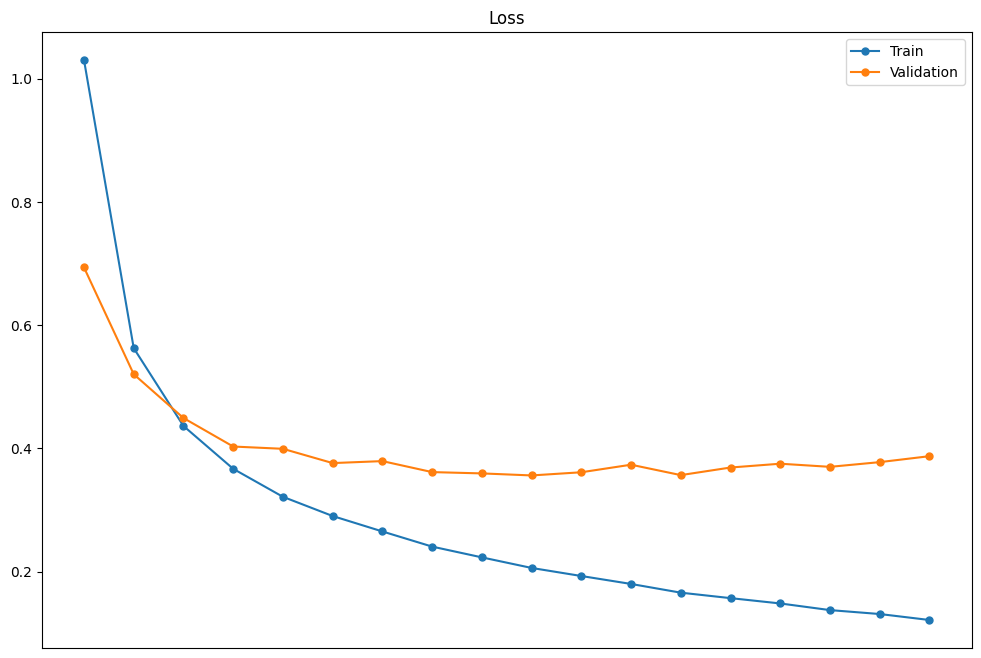

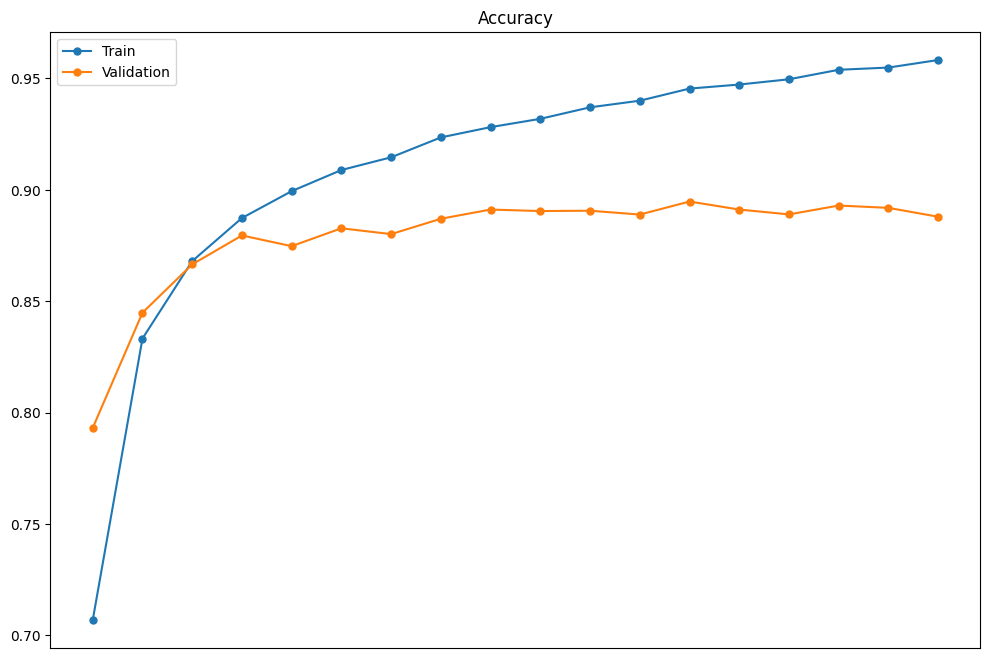

In [70]:
history_model1_df = pd.DataFrame(history_model0.history)
plot_loss(history_model1_df)
plot_accuracy(history_model1_df)

In [71]:
predictions_train_model1 = np.argmax(model1.predict(train_images), axis=-1)
predictions_test_model1 = np.argmax(model1.predict(test_images), axis=-1)

1943/1943 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [72]:
print_accuracy_scores(train_labels, test_labels, predictions_train_model1, predictions_test_model1)

Training set accuracy:   0.967
Test set accuracy:       0.884


# Modello 2

Questo modello rappresenta la prima rete CNN. Rispetto al modello 0 vengono aggiunti:
- un layer convoluzionale (viene applicato il tuning sul filtro del layer)
- un fattore di regoralizzazione L2 da apliccare ai layer di Dense

In [73]:
def model2_builder(hp): 
    k = hp.Choice("L2", l2)
    model2 = tf.keras.Sequential()
    model2.add(tf.keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)))
    model2.add(tf.keras.layers.Conv2D(hp.Choice("filter", filter), 3, padding="same", activation="relu"))
    model2.add(tf.keras.layers.MaxPooling2D())
    model2.add(tf.keras.layers.Flatten())
    model2.add(tf.keras.layers.Dense(hp.Choice("dense_units", dense_units), activation="relu", kernel_regularizer=tf.keras.regularizers.L2(k)))
    model2.add(tf.keras.layers.Dense(26, activation="softmax", kernel_regularizer=tf.keras.regularizers.L2(k)))
    
    model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model2

In [74]:
#tuning hyperparameters
tuner = kt.RandomSearch(model2_builder, kt.Objective('val_accuracy', direction='max'), 10, 42, project_name='tuners/nn2')
tuner.search(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)], batch_size=128)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from .\tuners/nn2\tuner0.json


In [75]:
print("Best Dense units: ", best_hps.get("dense_units"))
print("Best L2 value: ", best_hps.get("L2"))
print("Best Filter: ", best_hps.get("filter"))

Best Dense units:  256
Best L2 value:  0.0001
Best Filter:  16


In [76]:
model2 = tuner.hypermodel.build(best_hps)
model2.summary()

C:\Users\Damiano\PycharmProjects\machineLearning\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 809,914 (3.09 MB)

 Trainable params: 809,914 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
history_model2 = model2.fit(train_images, train_labels, batch_size=128, epochs=20, verbose=1, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)])

Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6410 - loss: 1.3336 - val_accuracy: 0.8541 - val_loss: 0.5507
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8737 - loss: 0.4839 - val_accuracy: 0.8908 - val_loss: 0.4385
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9029 - loss: 0.3896 - val_accuracy: 0.8988 - val_loss: 0.4022
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9179 - loss: 0.3393 - val_accuracy: 0.9055 - val_loss: 0.3980
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9261 - loss: 0.3147 - val_accuracy: 0.9069 - val_loss: 0.3815
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9320 - loss: 0.2922 - val_accuracy: 0.9085 - val_loss: 0.3743
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9372 - loss: 0.2760 - val_accuracy: 0.9084 - val_loss: 0.3843
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9397 - loss: 0.2667 - 

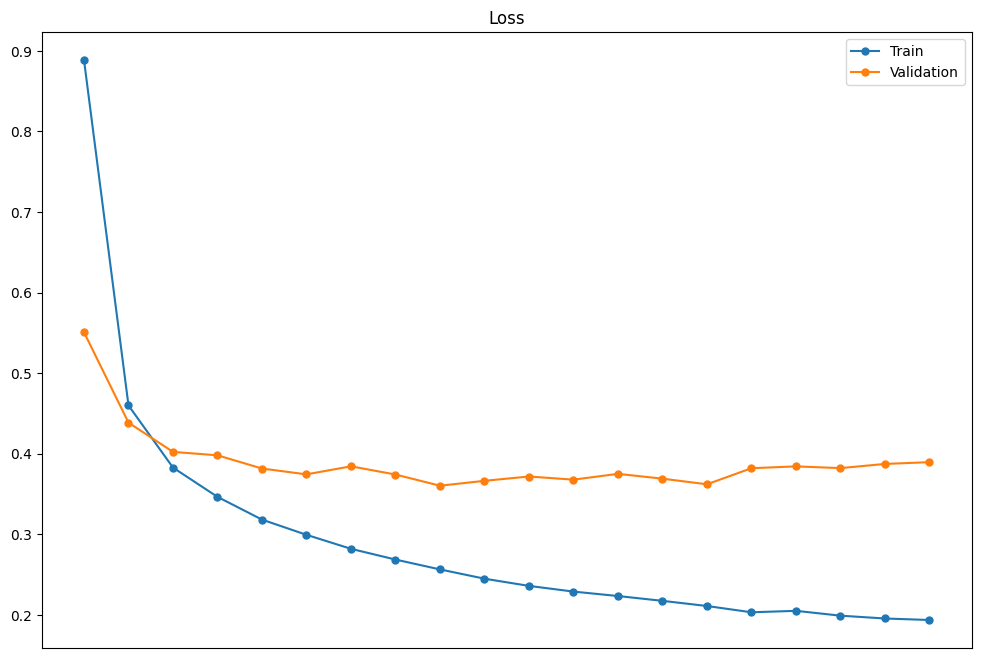

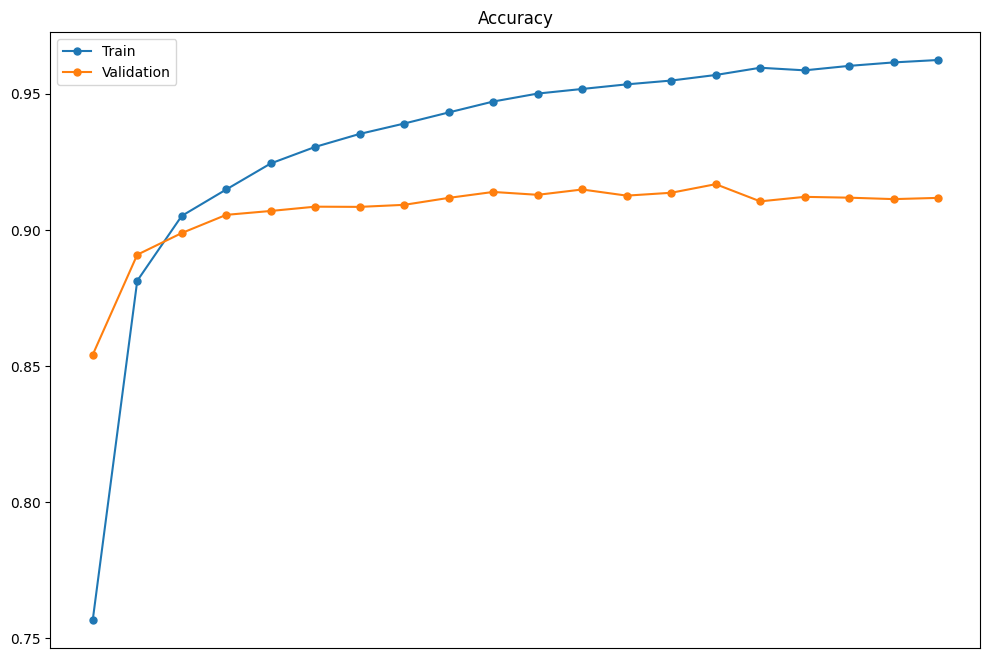

In [78]:
history_model2_df = pd.DataFrame(history_model2.history)
plot_loss(history_model2_df)
plot_accuracy(history_model2_df)

In [79]:
predictions_train_model2 = np.argmax(model2.predict(train_images), axis=-1)
predictions_test_model2 = np.argmax(model2.predict(test_images), axis=-1)

1943/1943 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [81]:
print_accuracy_scores(train_labels, test_labels, predictions_train_model2, predictions_test_model2)

Training set accuracy:   0.968
Test set accuracy:       0.908


# Modello 3

Per il terzo modello, viene introdotto un ulteriore layer convoluzionale e un layer di Dropout per marginare l'overfitting. Si hanno due set di filtri separati da applicare ai layer convoluzionali, e i valori per essi vengono scelti attraverso il tuning. Anche il rate di dropout è soggetto a tuning.

In [82]:
def model3_builder(hp): 
    filters_index = hp.Choice("filters_index", [0, 1])
    k = hp.Choice("L2", l2)
    model3 = tf.keras.Sequential()
    model3.add(tf.keras.layers.Rescaling(1./255, input_shape=(28,28,1)))
    model3.add(tf.keras.layers.Conv2D(filters[filters_index][0], 3, padding="same", activation="relu"))
    model3.add(tf.keras.layers.MaxPooling2D())
    model3.add(tf.keras.layers.Conv2D(filters[filters_index][1], 3, padding="same", activation="relu"))
    model3.add(tf.keras.layers.MaxPooling2D())
    model3.add(tf.keras.layers.Dropout(hp.Choice("dropout_rate", dropouts_rate)))
    model3.add(tf.keras.layers.Flatten())
    model3.add(tf.keras.layers.Dense(hp.Choice("dense_units", dense_units), activation="relu", kernel_regularizer=tf.keras.regularizers.L2(k)))
    model3.add(tf.keras.layers.Dense(26, activation="softmax", kernel_regularizer=tf.keras.regularizers.L2(k)))
    
    model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model3

In [83]:
tuner = kt.RandomSearch(model3_builder, kt.Objective('val_accuracy', direction='max'), 10, 42, project_name='tuners/nn3')
tuner.search(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)], batch_size=128)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from .\tuners/nn3\tuner0.json


In [84]:
print("Best Filter: ", filters[best_hps.get("filters_index")])
print("Best Dropout Rate: ", best_hps.get("dropout_rate"))
print("Best Dense units: ", best_hps.get("dense_units"))
print("Best L2 value: ",  best_hps.get("L2"))

Best Filter:  [32, 64, 128]
Best Dropout Rate:  0.5
Best Dense units:  64
Best L2 value:  0.001


In [85]:
model3 = tuner.hypermodel.build(best_hps)
model3.summary()

C:\Users\Damiano\PycharmProjects\machineLearning\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,274 (864.35 KB)

 Trainable params: 221,274 (864.35 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
history_model3 = model3.fit(train_images, train_labels, batch_size=128, epochs=20, verbose=1, validation_data=(val_images, val_labels), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)])

Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.5743 - loss: 1.5956 - val_accuracy: 0.8684 - val_loss: 0.5753
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8537 - loss: 0.6098 - val_accuracy: 0.9005 - val_loss: 0.4702
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8813 - loss: 0.5152 - val_accuracy: 0.9091 - val_loss: 0.4308
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8937 - loss: 0.4692 - val_accuracy: 0.9105 - val_loss: 0.4166
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9015 - loss: 0.4393 - val_accuracy: 0.9153 - val_loss: 0.3976
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9057 - loss: 0.4245 - val_accuracy: 0.9208 - val_loss: 0.3860
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9084 - loss: 0.4115 - val_accuracy: 0.9199 - val_loss: 0.3842
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9089 - loss: 0.4077 - 

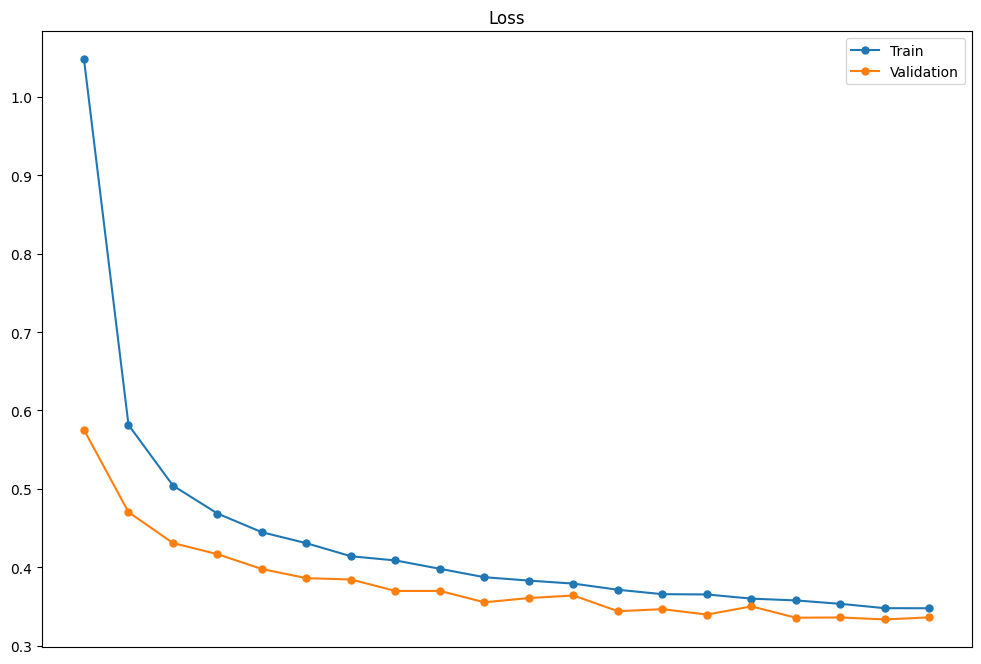

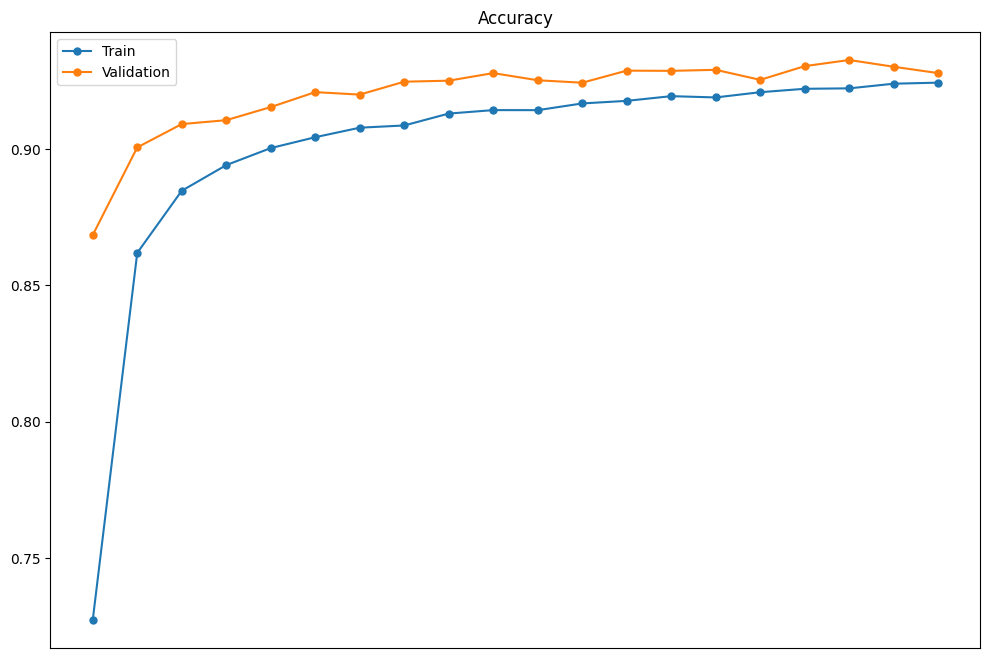

In [87]:
history_model3_df = pd.DataFrame(history_model3.history)
plot_loss(history_model3_df)
plot_accuracy(history_model3_df)

In [88]:
predictions_train_model3 = np.argmax(model3.predict(train_images), axis=-1)
predictions_test_model3 = np.argmax(model3.predict(test_images), axis=-1)

1943/1943 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [89]:
print_accuracy_scores(train_labels, test_labels, predictions_train_model3, predictions_test_model3)

Training set accuracy:   0.945
Test set accuracy:       0.926
